In [1]:
from datetime import datetime

In [2]:
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2020-09-26 18:34:46.048404


In [3]:
!git clone -b week9-dev https://github.com/vamsigp/EVA5/

Cloning into 'EVA5'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (379/379), done.
remote: Compressing objects: 100% (283/283), done.
remote: Total 379 (delta 195), reused 237 (delta 81), pack-reused 0
Receiving objects: 100% (379/379), 15.10 MiB | 13.26 MiB/s, done.
Resolving deltas: 100% (195/195), done.


In [4]:
%cd EVA5/trainer

/content/EVA5/trainer


In [5]:
!pip install -U albumentations

     |████████████████████████████████| 122kB 9.0MB/s 
     |████████████████████████████████| 952kB 9.6MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=5fb8015ab72ae4ec3d51ccd2cf454dd35136863cd8c511a93bd636453d6a3d7f
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [6]:
%matplotlib inline

In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from config import ModelConfig
from data_engine import DataEngine
from trainer import Trainer
from results import *
from utils import *

In [8]:
from Albumentations import *
from GradCAM import *

Quiz Model

In [9]:
from models.QuizDNN import QuizDNN

In [10]:
transform_album = album_compose()

In [11]:
# View model config
args = ModelConfig(transform_album)
args.print_config()

print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout_value': 0.15,
  'epochs': 50,
  'num_workers': 4,
  'seed': 1,
  'train_transform': <Albumentations.album_compose object at 0x7f7164f5acf8>}

CUDA Available


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer


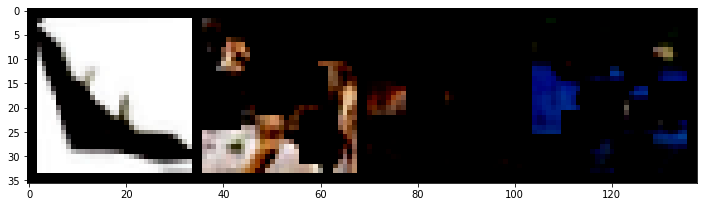

In [12]:
data = DataEngine(args)

# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))

In [13]:
device = which_device()
# model = Net(args).to(device)
# model = ResNet18().to(device)
model = QuizDNN().to(device)
show_model_summary(model, device, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              96
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,216
      BatchNorm2d-10           [-1, 32, 32, 32]              64
             ReLU-11           [-1, 32, 32, 32]               0
          Dropout-12           [-1, 32, 32, 32]               0
        MaxPool2d-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1, 64,

In [15]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
# scheduler = OneCycleLR(optimizer,max_lr=0.1,total_steps=20)

In [18]:
trainer = Trainer(model, 
                  device,
                  train_loader=data.train_loader, 
                  test_loader = data.test_loader, 
                  optimizer = optimizer, 
                  loss_func = criterion, 
                  lr_scheduler = None) 

In [19]:
(train_loss, train_acc, test_loss, test_acc) = trainer.train_model(epochs=40, lambda_l1=0.0001)

Train set: Loss=2.9496259689331055 Batch_id=781 Accuracy=28.86: 100%|██████████| 782/782 [00:19<00:00, 39.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 2795/10000 (27.95%)



Train set: Loss=2.746382236480713 Batch_id=781 Accuracy=38.35: 100%|██████████| 782/782 [00:19<00:00, 39.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 3575/10000 (35.75%)



Train set: Loss=2.373182773590088 Batch_id=781 Accuracy=43.98: 100%|██████████| 782/782 [00:19<00:00, 39.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 4401/10000 (44.01%)



Train set: Loss=2.567915916442871 Batch_id=781 Accuracy=47.67: 100%|██████████| 782/782 [00:19<00:00, 39.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 4206/10000 (42.06%)



Train set: Loss=2.4810397624969482 Batch_id=781 Accuracy=50.39: 100%|██████████| 782/782 [00:19<00:00, 39.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 5129/10000 (51.29%)



Train set: Loss=2.273379325866699 Batch_id=781 Accuracy=52.53: 100%|██████████| 782/782 [00:19<00:00, 39.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 5164/10000 (51.64%)



Train set: Loss=2.101938486099243 Batch_id=781 Accuracy=54.43: 100%|██████████| 782/782 [00:19<00:00, 39.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 5204/10000 (52.04%)



Train set: Loss=1.6741511821746826 Batch_id=781 Accuracy=56.04: 100%|██████████| 782/782 [00:19<00:00, 39.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 5625/10000 (56.25%)



Train set: Loss=1.7183802127838135 Batch_id=781 Accuracy=57.69: 100%|██████████| 782/782 [00:19<00:00, 39.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 5770/10000 (57.70%)



Train set: Loss=1.7196424007415771 Batch_id=781 Accuracy=58.56: 100%|██████████| 782/782 [00:19<00:00, 39.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 5946/10000 (59.46%)



Train set: Loss=1.8192989826202393 Batch_id=781 Accuracy=59.78: 100%|██████████| 782/782 [00:19<00:00, 39.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 6120/10000 (61.20%)



Train set: Loss=1.644564151763916 Batch_id=781 Accuracy=60.77: 100%|██████████| 782/782 [00:20<00:00, 38.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 6037/10000 (60.37%)



Train set: Loss=1.5474460124969482 Batch_id=781 Accuracy=61.68: 100%|██████████| 782/782 [00:20<00:00, 39.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 6154/10000 (61.54%)



Train set: Loss=2.0378663539886475 Batch_id=781 Accuracy=62.37: 100%|██████████| 782/782 [00:20<00:00, 38.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0143, Accuracy: 6741/10000 (67.41%)



Train set: Loss=1.3279857635498047 Batch_id=781 Accuracy=63.17: 100%|██████████| 782/782 [00:19<00:00, 39.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 6218/10000 (62.18%)



Train set: Loss=1.1293703317642212 Batch_id=781 Accuracy=64.02: 100%|██████████| 782/782 [00:19<00:00, 39.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 6487/10000 (64.87%)



Train set: Loss=1.546353816986084 Batch_id=781 Accuracy=64.43: 100%|██████████| 782/782 [00:20<00:00, 38.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 6350/10000 (63.50%)



Train set: Loss=1.6439083814620972 Batch_id=781 Accuracy=65.01: 100%|██████████| 782/782 [00:19<00:00, 39.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0144, Accuracy: 6802/10000 (68.02%)



Train set: Loss=1.9240121841430664 Batch_id=781 Accuracy=65.72: 100%|██████████| 782/782 [00:19<00:00, 39.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0136, Accuracy: 6965/10000 (69.65%)



Train set: Loss=1.2496507167816162 Batch_id=781 Accuracy=66.33: 100%|██████████| 782/782 [00:19<00:00, 39.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0149, Accuracy: 6649/10000 (66.49%)



Train set: Loss=1.4380697011947632 Batch_id=781 Accuracy=66.45: 100%|██████████| 782/782 [00:20<00:00, 39.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0132, Accuracy: 7055/10000 (70.55%)



Train set: Loss=1.2003357410430908 Batch_id=781 Accuracy=66.97: 100%|██████████| 782/782 [00:19<00:00, 39.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0142, Accuracy: 6720/10000 (67.20%)



Train set: Loss=1.777101755142212 Batch_id=781 Accuracy=67.75: 100%|██████████| 782/782 [00:19<00:00, 39.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0126, Accuracy: 7162/10000 (71.62%)



Train set: Loss=1.3738760948181152 Batch_id=781 Accuracy=68.17: 100%|██████████| 782/782 [00:19<00:00, 39.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 6925/10000 (69.25%)



Train set: Loss=1.516611933708191 Batch_id=781 Accuracy=68.62: 100%|██████████| 782/782 [00:19<00:00, 39.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0110, Accuracy: 7548/10000 (75.48%)



Train set: Loss=1.5590182542800903 Batch_id=781 Accuracy=68.66: 100%|██████████| 782/782 [00:19<00:00, 39.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 7351/10000 (73.51%)



Train set: Loss=1.0681984424591064 Batch_id=781 Accuracy=69.31: 100%|██████████| 782/782 [00:19<00:00, 39.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0124, Accuracy: 7264/10000 (72.64%)



Train set: Loss=1.5941855907440186 Batch_id=781 Accuracy=69.91: 100%|██████████| 782/782 [00:19<00:00, 39.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0122, Accuracy: 7298/10000 (72.98%)



Train set: Loss=1.6418708562850952 Batch_id=781 Accuracy=70.13: 100%|██████████| 782/782 [00:19<00:00, 39.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0118, Accuracy: 7418/10000 (74.18%)



Train set: Loss=0.9386736154556274 Batch_id=781 Accuracy=70.15: 100%|██████████| 782/782 [00:19<00:00, 39.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0138, Accuracy: 6897/10000 (68.97%)



Train set: Loss=1.2557682991027832 Batch_id=781 Accuracy=70.65: 100%|██████████| 782/782 [00:19<00:00, 39.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0106, Accuracy: 7640/10000 (76.40%)



Train set: Loss=1.7390068769454956 Batch_id=781 Accuracy=70.88: 100%|██████████| 782/782 [00:20<00:00, 38.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 7307/10000 (73.07%)



Train set: Loss=1.2253042459487915 Batch_id=781 Accuracy=71.14: 100%|██████████| 782/782 [00:19<00:00, 39.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0125, Accuracy: 7196/10000 (71.96%)



Train set: Loss=1.0809006690979004 Batch_id=781 Accuracy=71.25: 100%|██████████| 782/782 [00:20<00:00, 38.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0118, Accuracy: 7357/10000 (73.57%)



Train set: Loss=0.9699693322181702 Batch_id=781 Accuracy=71.47: 100%|██████████| 782/782 [00:19<00:00, 39.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 7285/10000 (72.85%)



Train set: Loss=1.8708440065383911 Batch_id=781 Accuracy=71.62: 100%|██████████| 782/782 [00:19<00:00, 39.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Accuracy: 7471/10000 (74.71%)



Train set: Loss=1.0153934955596924 Batch_id=781 Accuracy=71.93: 100%|██████████| 782/782 [00:19<00:00, 39.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Accuracy: 7740/10000 (77.40%)



Train set: Loss=0.7626410722732544 Batch_id=781 Accuracy=71.82: 100%|██████████| 782/782 [00:20<00:00, 38.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 7427/10000 (74.27%)



Train set: Loss=1.1721293926239014 Batch_id=781 Accuracy=72.50: 100%|██████████| 782/782 [00:19<00:00, 39.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Accuracy: 7783/10000 (77.83%)



Train set: Loss=0.9153926372528076 Batch_id=781 Accuracy=72.47: 100%|██████████| 782/782 [00:19<00:00, 39.27it/s]



Test set: Average loss: 0.0105, Accuracy: 7666/10000 (76.66%)



In [20]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
			'frog', 'horse', 'ship', 'truck')

In [21]:
trainer.classwise_acc(classes)


Accuracy of plane : 83 %
Accuracy of   car : 89 %
Accuracy of  bird : 70 %
Accuracy of   cat : 73 %
Accuracy of  deer : 62 %
Accuracy of   dog : 64 %
Accuracy of  frog : 85 %
Accuracy of horse : 85 %
Accuracy of  ship : 89 %
Accuracy of truck : 68 %



In [22]:
misclassified_imgs = trainer.get_misclassified()

/content/EVA5/trainer/trainer.py:127: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  misclassified_inds = (is_correct == 0).nonzero()[:, 0]


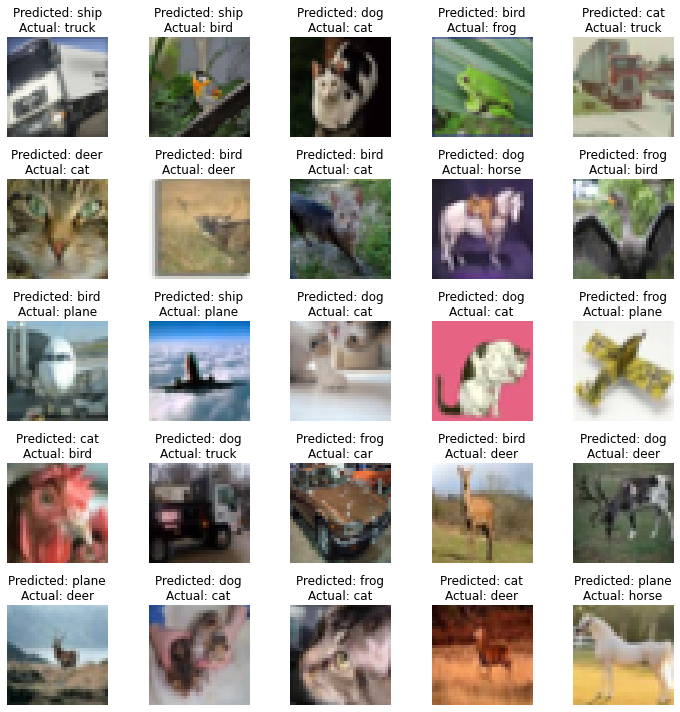

In [23]:
plot_misclassified_images(misclassified_imgs, classes, "misclassified_images1.png")

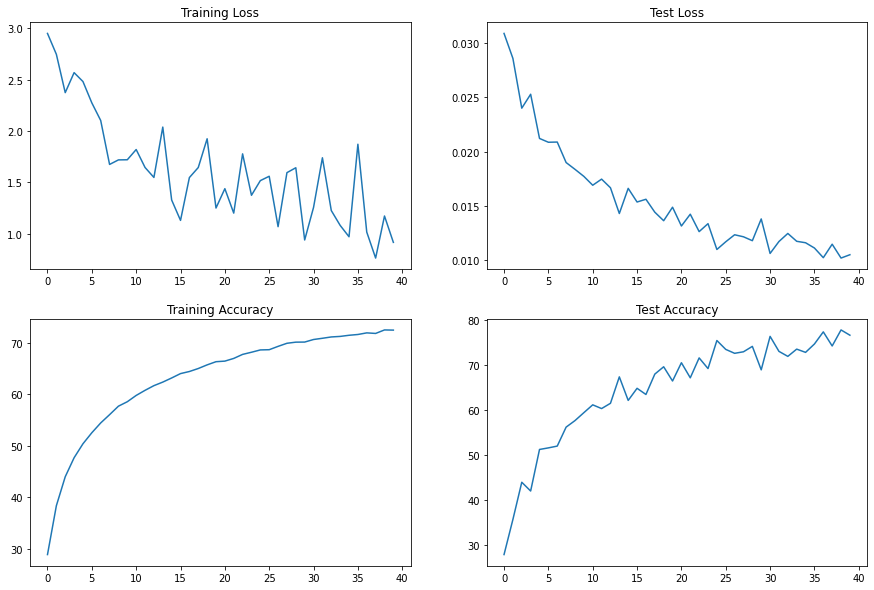

In [24]:
from results import plot_metrics
plot_metrics(train_loss, train_acc, test_loss, test_acc)

In [25]:
dataiter = iter(data.test_loader)
images, labels = dataiter.next()

In [26]:
for name, layer in model.named_modules():
  if isinstance(layer, torch.nn.Conv2d):
    print(name, layer)

convblock1.0 Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
convblock2.0 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
convblock3.0 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
convblock4.0 Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
convblock5.0 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
convblock6.0 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
convblock7.0 Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
convblock8.0 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
convblock9.0 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
convblock10.0 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
convblock11.0 Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [27]:
import PIL
import numpy as np

In [29]:
def plot_images_gradcam(torch_img,normed_torch_img, model):
    images=[]
    g1 = GradCAM(model, model.convblock9)
    g2 = GradCAM(model, model.convblock8)
    g3 = GradCAM(model, model.convblock7)
    g4 = GradCAM(model, model.convblock6)
    mask1, _ = g1(normed_torch_img)
    mask2, _ = g2(normed_torch_img)
    mask3, _ = g3(normed_torch_img)
    mask4, _ = g4(normed_torch_img)
    heatmap1, result1 = visualize_cam(mask1, torch_img)
    heatmap2, result2 = visualize_cam(mask2, torch_img)
    heatmap3, result3 = visualize_cam(mask3, torch_img)
    heatmap4, result4 = visualize_cam(mask4, torch_img)

    images.extend([torch_img.cpu(), heatmap1, heatmap2, heatmap3, heatmap4])
    images.extend([torch_img.cpu(), result1, result2, result3, result4])
    grid_image = make_grid(images, nrow=5)
    imshow(grid_image)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


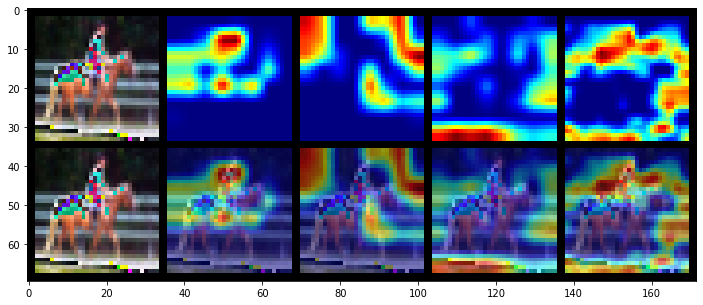

In [30]:
trans = transforms.ToPILImage()
pil_img=trans(torchvision.utils.make_grid(images[1]))
torch_img,normed_torch_img=change(pil_img,device)
plot_images_gradcam(torch_img,normed_torch_img, model)